<a href="https://colab.research.google.com/github/d9249/DACON/blob/main/CVLC_Pytorch_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive accept

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lib install

In [30]:
!pip install -U statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


# Lib

In [31]:
import time
import random
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import seaborn as sns

from tensorflow.keras.utils import to_categorical
import cv2

## Data Load

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/train.csv')
train_digit = train['digit'].values
train_letter = train['letter'].values
train_img = train.iloc[:,3:].values.reshape(-1, 28, 28, 1).astype(np.int)

test  = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/test.csv')
test_img = test.iloc[:,2:].values.reshape(-1, 28, 28, 1).astype(np.int)
X_test_letter = test['letter'].values

submission = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/submission.csv')

train_data = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/test.csv')

In [ ]:
print('digit  : ', np.unique(train_digit))
print('letter : ', np.unique(train_letter))

In [33]:
torch.cuda.is_available()

True

In [34]:
train.set_index('id').head()

,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,1,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,2,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,1,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,4,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,2,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [35]:
test.set_index('id').head()

,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,4,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,3,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,1,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,3,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4


In [36]:
train.shape

(2048, 787)

In [37]:
test.shape

(20480, 786)

# visualize
### 시각화를 통해 추측할 수 있는 내용
- fig
    - left fig : 원본 데이터
    - right fig : 숫자 부분이라 생각되는 부분을 임의로 추출
- letter는 영어 알파벳인데 데이터에는 모두 대문자로 있지만 이미지는 대소문자 구분이 없는 것을 확인 했습니다. 즉, 실제로는 A-Z(26), a-z(26) 으로 52개가 있는 것으로 보입니다.
- 이미지를 봤을 때 데이터가 만들어진 과정을 추측해보면 letter가 먼저 그려지고 digit을 그리는데 이 때 digit은 letter와 겹치는 부분만 남기고 나머지 부분은 제거하는 방식 인 것 같습니다. -> 단지 제 생각입니다...!
- 겹쳐져 있는 부분의 pixel 값은 약간 다른 것을 확인할 수 있었습니다.
- 임의로 일정 pixel 이상의 값을 가진 것만 남겨 이미지를 출력해보면 어떤 형태로 데이터가 생성 됐을지 예상할 수 있습니다.

In [ ]:
for idx in range(0, 300, 3):
    plt.figure(figsize=(20,30))
    plt.subplot(1,9,1)
    plt.imshow(train_img[idx].reshape(28,28),cmap='gray')
    plt.axis('off')
    
    plt.title('digit:{}   letter:{}'.format(train_digit[idx], train_letter[idx]), loc='left', fontsize=20)

    plt.subplot(1,9,2)
    data = np.where(train_img>=150, train_img, 0)
    plt.imshow(data[idx].reshape(28,28),cmap='gray')
    plt.axis('off')

    plt.subplot(1,9,3)
    plt.imshow(np.zeros((28,28,3))+1,cmap='gray')
    plt.axis('off')
    
    
    plt.subplot(1,9,4)
    plt.imshow(train_img[idx+1].reshape(28,28),cmap='gray')
    plt.axis('off')
    
    plt.title('digit:{}   letter:{}'.format(train_digit[idx+1], train_letter[idx+1]), loc='left', fontsize=20)

    plt.subplot(1,9,5)
    data = np.where(train_img>=150, train_img, 0)
    plt.imshow(data[idx+1].reshape(28,28),cmap='gray')
    plt.axis('off')

    plt.subplot(1,9,6)
    plt.imshow(np.zeros((28,28,3))+1,cmap='gray')
    plt.axis('off')
    
    
    plt.subplot(1,9,7)
    plt.imshow(train_img[idx+2].reshape(28,28),cmap='gray')
    plt.axis('off')
    
    plt.title('digit:{}   letter:{}'.format(train_digit[idx+2], train_letter[idx+2]), loc='left', fontsize=20)

    plt.subplot(1,9,8)
    data = np.where(train_img>=150, train_img, 0)
    plt.imshow(data[idx+2].reshape(28,28),cmap='gray')
    plt.axis('off')

    plt.subplot(1,9,9)
    plt.imshow(np.zeros((28,28,3))+1,cmap='gray')
    plt.axis('off')
    
plt.show()

- letter 정보를 어떻게 활용할 수 있을지. -> letter의 값을 one-hot-vector로 만든 후 layer의 입력으로 활용해 보는 것도 ? ..
- 적은 데이터를 통해 어떤 방식을 활용하면 효율적인 학습을 할 수 있을지.
- public LB는 20480개중 1%의 데이터로 약 205개 정도로만 측정이되니 나중에 전체 데이터로 측정 될 때는 또 다르게 나올 수 있을 것 같습니다.

# Dataset의 분포 

In [38]:
train_df_letter = train['letter'].values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


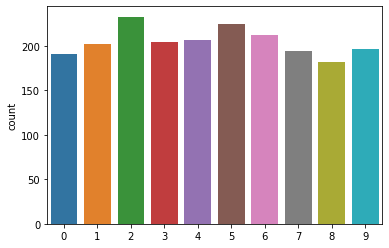

In [39]:
sns.countplot(train.digit.values)

# 숫자별 알파벳 빈도

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

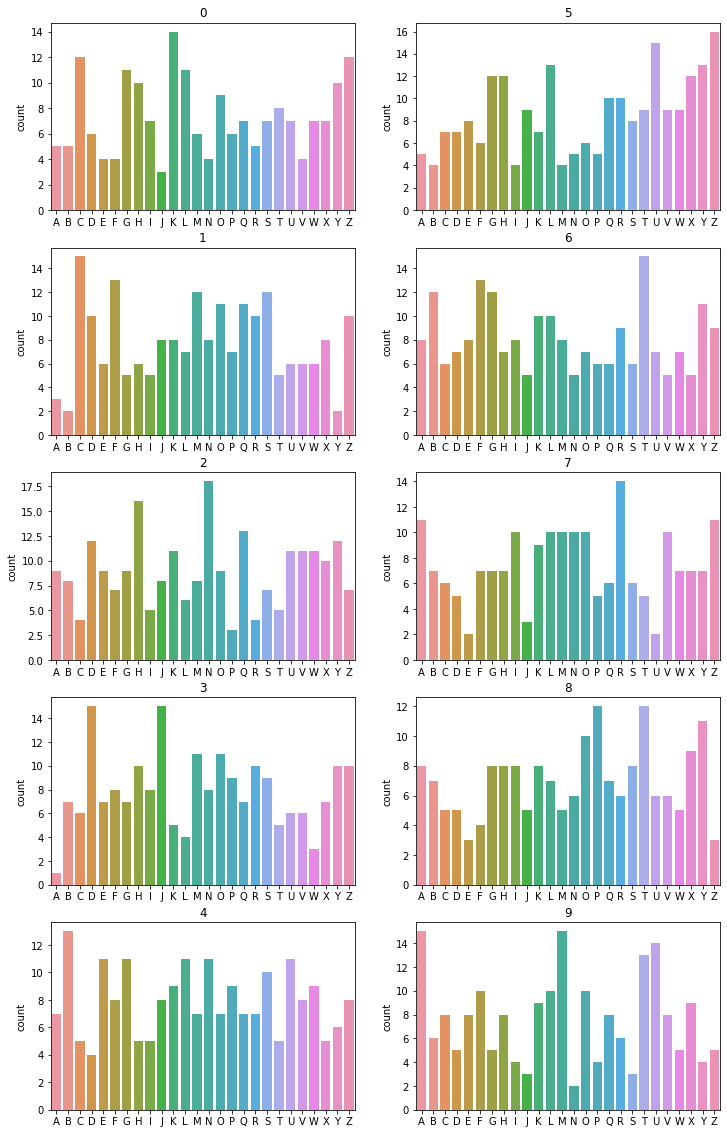

In [40]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(12,20))

col = 0
row = 0

for target_number in range(10): 
    if row == 5 and col==0:
        col+=1
        row = 0
    
    sns.countplot(sorted(train.loc[train.digit==target_number,'letter'].values), ax=axes[row,col]).set_title(str(target_number))
    row+=1

# 알파벳별 숫자 빈도

In [41]:
letter_unique = train['letter'].values
unique_letter = set(letter_unique)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

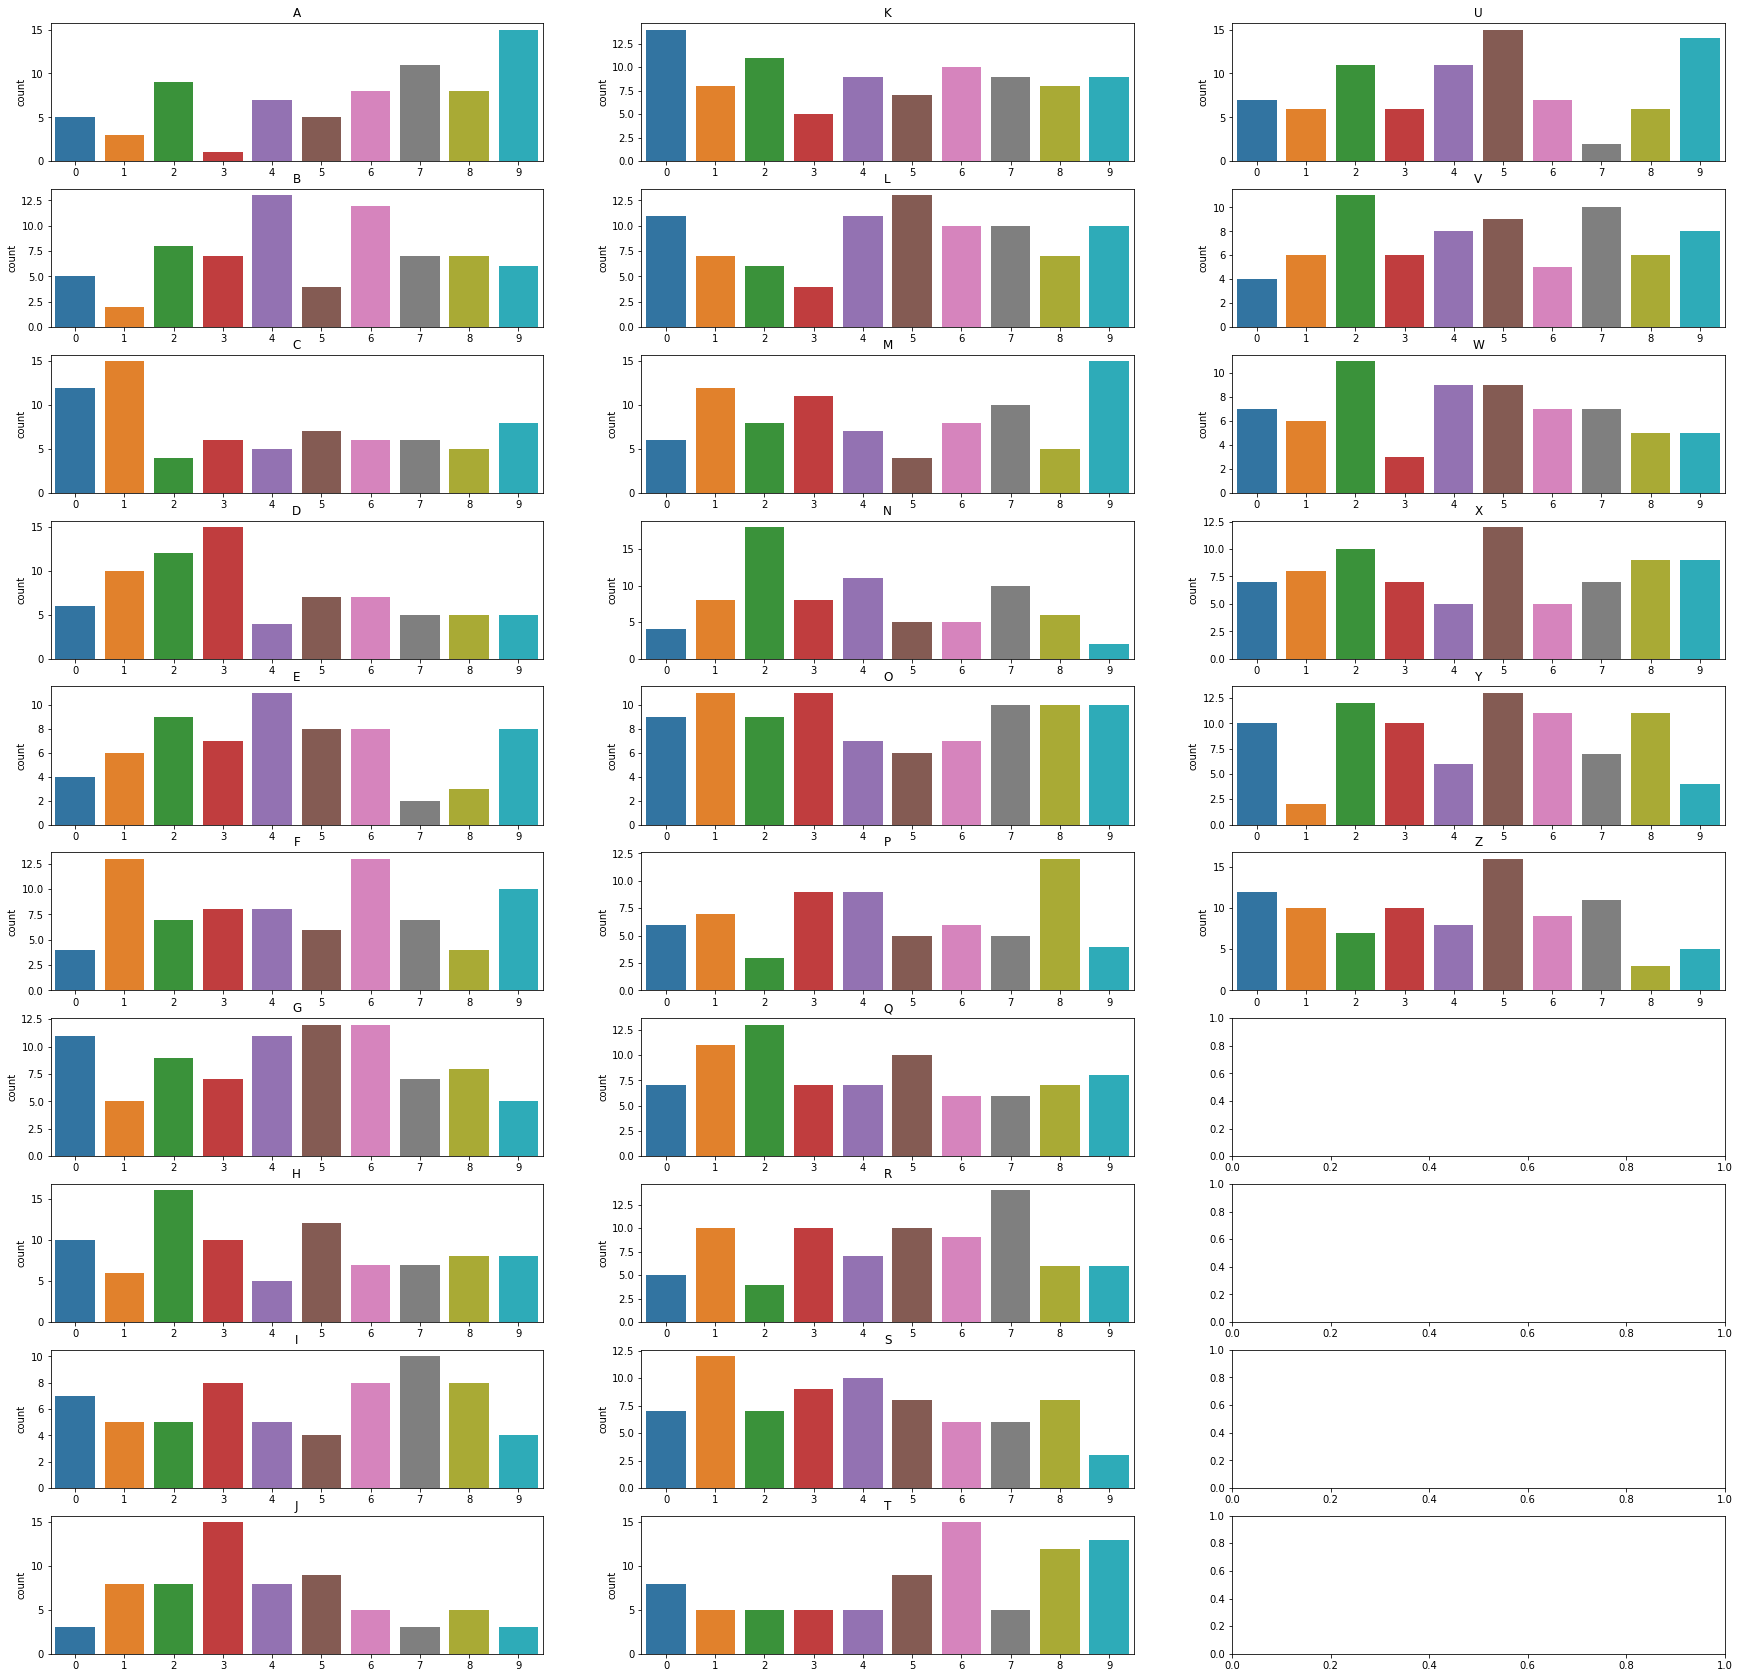

In [42]:
fig, axes = plt.subplots(nrows=10, ncols=3,figsize=(30,30))

col = 0
row = 0

for target_letter in sorted(list(unique_letter)): 
    if row == 10: #and col==0:
        col+=1
        row = 0
    
    sns.countplot(train.loc[train.letter==target_letter,'digit'].values, ax=axes[row,col]).set_title(str(target_letter))
    row+=1

# Train 이미지 분석

In [43]:
def show_10_imgs(imgs):
    plt.figure(figsize=(20, 5))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [44]:
def save_10_imgs(imgs):
    plt.figure(figsize=(20, 5))
    for i in range(10):
        plt.imshow(imgs[i])
        plt.savefig(f"{i}.png")

    plt.show()

In [45]:
def imgs_save(imgs):
    plt.figure(figsize=(20, 5))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.savefig(i+'.png', imgs[i])

In [46]:
X_train = np.array(train_data.drop(['id', 'digit', 'letter'], axis=1)).astype('float32')
X_test = np.array(test_data.drop(['id', 'letter'], axis=1)).astype('float32')

y_train = to_categorical(np.array(train_data['digit']), num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1004)

X_train = X_train.reshape((X_train.shape[0], 28, 28))
X_val = X_val.reshape((X_val.shape[0], 28, 28))
X_test = X_test.reshape((X_test.shape[0], 28, 28))

## 원본 숫자 이미지

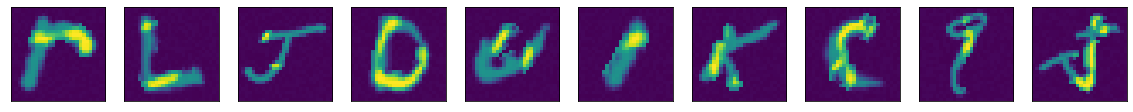

In [47]:
show_10_imgs(X_train)

In [48]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

threshold = 0.6
X_train[X_train > threshold] = 0
X_val[X_val > threshold] = 0
X_test[X_test > threshold] = 0

## 숫자가 있어서는 안되는 영역

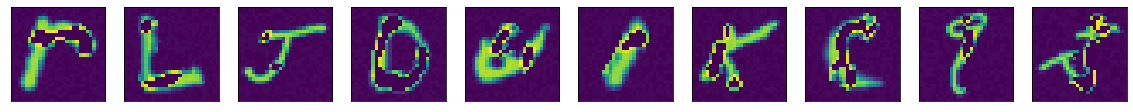

In [49]:
show_10_imgs(X_train)

In [50]:
X_train = np.array(train_data.drop(['id', 'digit', 'letter'], axis=1)).astype('float32')
X_test = np.array(test_data.drop(['id', 'letter'], axis=1)).astype('float32')

y_train = to_categorical(np.array(train_data['digit']), num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1004)

X_train = X_train.reshape((X_train.shape[0], 28, 28))
X_val = X_val.reshape((X_val.shape[0], 28, 28))
X_test = X_test.reshape((X_test.shape[0], 28, 28))

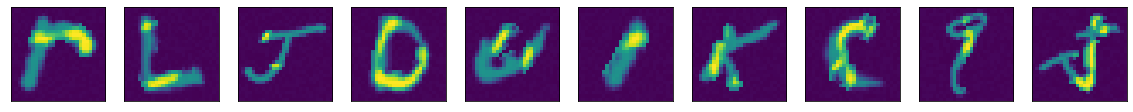

In [51]:
show_10_imgs(X_train)

In [52]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

threshold = 0.6
X_train[X_train < threshold] = 0
X_val[X_val < threshold] = 0
X_test[X_test < threshold] = 0

## 숫자가 무조건 있는 영역

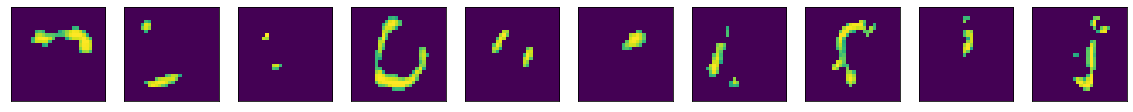

In [53]:
show_10_imgs(X_train)

In [54]:
digit_ref = np.zeros((10, 28, 28))
for (idx, digit) in enumerate(y_train):
    digit = np.argmax(digit)
    digit_ref[digit] += X_train[idx]

digit_ref = digit_ref / np.max(digit_ref)

## 전체  Train Data에서 보이는 숫자 부분의 모든 이미지를 겹친 이미지 
( 0~9의 숫자를 가장 잘 나타내는 영역의 시각화 )  

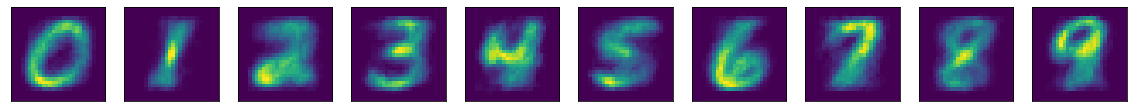

In [55]:
show_10_imgs(digit_ref)

In [56]:
digit_ref[digit_ref < 0.1] = 0

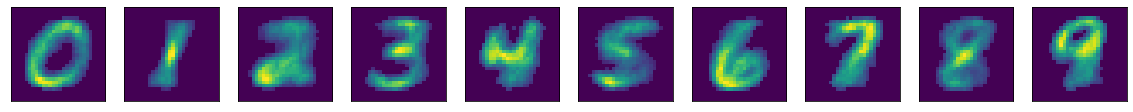

In [57]:
show_10_imgs(digit_ref)

In [58]:
digit_ref[digit_ref < 0.2] = 0

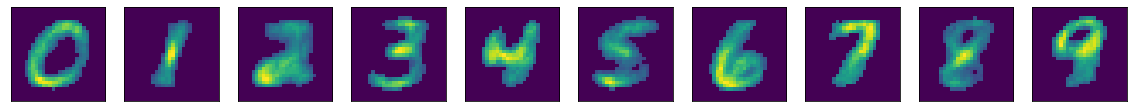

In [59]:
show_10_imgs(digit_ref)

In [60]:
digit_ref[digit_ref < 0.2] = 0

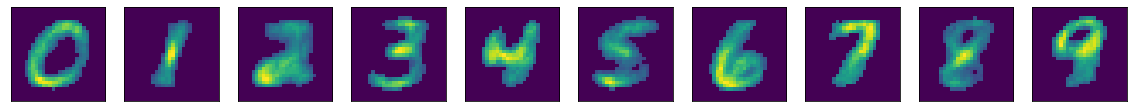

In [61]:
show_10_imgs(digit_ref)

In [62]:
digit_ref[digit_ref < 0.3] = 0

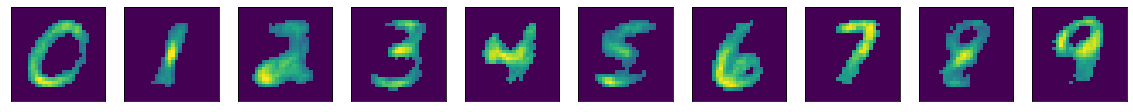

In [63]:
show_10_imgs(digit_ref)

In [64]:
digit_ref[digit_ref < 0.4] = 0

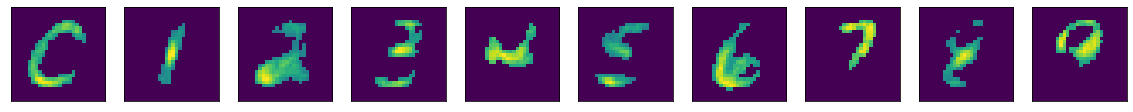

In [65]:
show_10_imgs(digit_ref)

In [66]:
digit_ref[digit_ref < 0.5] = 0

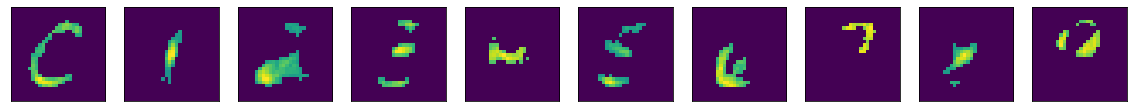

In [67]:
show_10_imgs(digit_ref)

In [68]:
digit_ref[digit_ref < 0.6] = 0

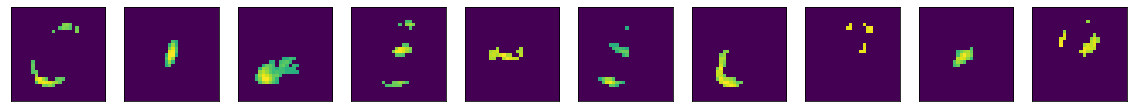

In [69]:
show_10_imgs(digit_ref)

## 위의 예시 중 0~9의 숫자를 가장 잘 나타내는 이미지 

In [70]:
digit_ref = np.zeros((10, 28, 28))
for (idx, digit) in enumerate(y_train):
    digit = np.argmax(digit)
    digit_ref[digit] += X_train[idx]

digit_ref = digit_ref / np.max(digit_ref)

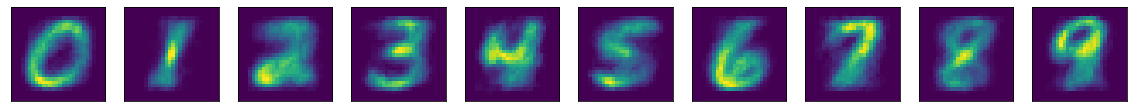

In [71]:
show_10_imgs(digit_ref)

In [72]:
digit_ref[digit_ref < 0.25] = 0

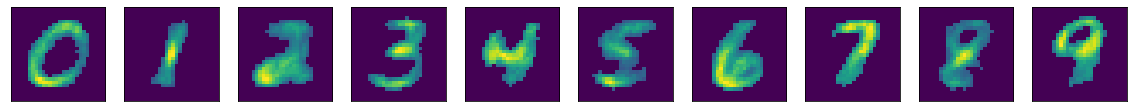

In [73]:
show_10_imgs(digit_ref)

In [74]:
digit_ref[digit_ref != 0] = 1

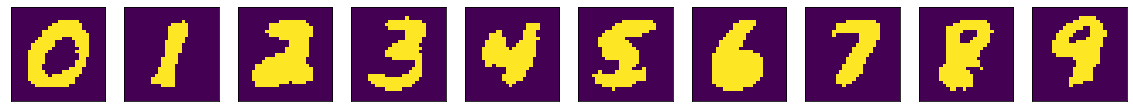

In [75]:
show_10_imgs(digit_ref)

# IDEA

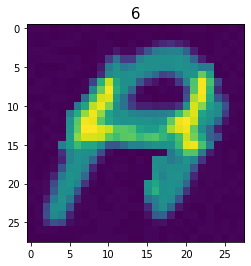

In [76]:
i = 0
img = train.query("letter == 'A'")[
        [(str(i)) for i in range(784)]
    ].iloc[28].values.reshape(28, 28)
plt.imshow(img)
plt.title(train.query("letter == 'A'").iloc[i]['digit'], fontsize=15)
plt.show()

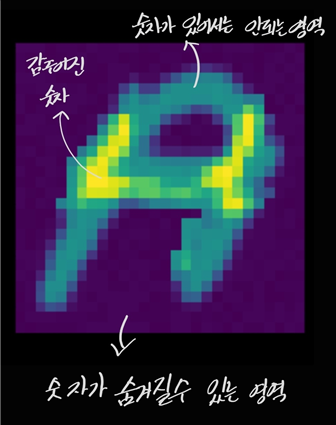

IDEA
 - 무조건 적으로 숫자가 보이는 부분과 숫자가 존재해서는 안되는 영역이 명확하게 존재하므로 이를 이용하여 학습을 진행한다면, 높은 정확도를 보일 수 있을 것 같다.

1. 3개의 라벨을 구분 후 함께 같이 학습 시킨다.
    1. train_a = 감추어진 숫자가 있는 이미지
    2. train_b = 숫자가 숨겨질 수 있는 부분의 이미지
    3. train_c = 숫자가 있어서는 안되는 부분의 이미지

학습에 사용될 데이터 
 - letter 숫자를 가리는 알파벳에 대한 정보
 - 숨겨진 숫자의 대한 정보 
 - 그리고 위에 3개에 대한 정보

Task
 - 여러 개의 라벨을 가진 이미지에 대한 학습의 성능이 좋은 모델을 알아봐야한다.
 - Train Data set이 부족하기 때문에 이를 보완할 방법을 찾아야한다.

In [77]:
train.query("letter == 'A'").iloc[28].iloc[:3]

id        774
digit       4
letter      A
Name: 773, dtype: object

In [78]:
from scipy.signal import correlate2d

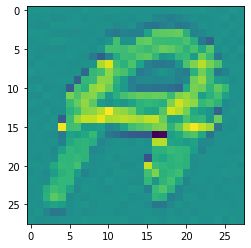

In [79]:
# 이런 식으로 특성을 파악하는 것이 목적이다.

kernel = np.array(
    [
        [0, -100, 0],
        [0, 255, 0],
        [0, -100, 0],
    ]
)
plt.imshow(correlate2d(img, kernel, mode='same'))

In [80]:
# 문자는 one-hot encoding한 후에 (-1, 1, 26)으로 reshape
# pixel값들도 (-1, 1, 784)로 reshape
# 그 후 concat하여 (2048, 1, 810)으로 X_train 구축
X_train = np.concatenate(
    [
        pd.get_dummies(train.letter).values.reshape(-1, 1, 26),
        (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ], 
    axis=2
)
# Label Setting
y_train = train['digit'].values

# Train-Test를 8:2로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [81]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1638, 1, 810), (410, 1, 810), (1638,), (410,))

# Train

In [82]:
# Torch.Tensor로 형변환
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [83]:
from torch.utils.data import (
    TensorDataset, 
    DataLoader, 
    RandomSampler, 
    SequentialSampler
)


# 배치 사이즈
batch_size = 4

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(
    X_train[:, :, :26], # Letter
    X_train[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_train # Label
)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(
    X_valid[:, :, :26], # Letter
    X_valid[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_valid # Label
)
validation_sampler = SequentialSampler(
    validation_data)
validation_dataloader = DataLoader(
    validation_data, sampler=validation_sampler, batch_size=batch_size)

In [84]:
# Model Construct

class ConvClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Letter를 처리할 1D Conv Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv1d(16, 64, 4, padding=1), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding=2), nn.ReLU(),
            nn.Conv1d(128, 64, 4, padding=2), nn.ReLU(),
            nn.Conv1d(64, 16, 3), nn.ReLU(),
        )
        
        # Image를 처리할 2D Conv Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 128, 5, padding=2), nn.ReLU(),
            nn.Conv2d(128, 256, 7, padding=3), nn.ReLU(),
            nn.Conv2d(256, 512, 9, padding=3), nn.ReLU(),
            nn.Conv2d(512, 256, 9, padding=3), nn.ReLU(),
            nn.Conv2d(256, 128, 7, padding=3), nn.ReLU(),
            nn.Conv2d(128, 64, 7, padding=3), nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding=3), nn.ReLU(),
        )
        
        # 위 두 블럭을 지나 concat후 Fully Connected를 지나
        # label을 예측
        self.out = nn.Sequential(
            nn.Linear(22016, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        # 다중 Label이므로 Cross Entropy Loss를 정의
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            # label이 입력으로 들어오면 loss도 계산해서 return
            loss = self.loss(out, label)
            return (out, loss)
        # label이 입력되지 않으면 ``self._inference``와 동일.
        return out
    
    def _inference(self, x1, x2):
        bsz = x1.size(0)
        
        x1 = self.conv1(x1)
        x2 = self.conv2(x2)
        
        x1 = x1.view(bsz, -1)
        x2 = x2.view(bsz, -1)
        
        x = torch.cat([x1, x2], dim=1)
#         return x
        out = F.softmax(self.out(x), dim=1)
        
        return out

In [85]:
# Model 구축
model = ConvClassifier()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (9): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): Conv2d(512, 256, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (9): ReLU()
    (10): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1),

In [86]:
# 입력이 제대로 들어갈 지 확인
x1 = X_train[:32, :, :26].cuda()
x2 = X_train[:32, :, 26:].reshape(-1, 1, 28, 28).cuda()

model(x1, x2).shape

torch.Size([32, 10])

In [87]:
from torch.optim import Adam

# 옵티마이저 설정
optimizer = Adam(
    model.parameters(),
    lr=2e-5, # 학습률
    eps=1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
)

# 에폭수
epochs = 150

In [88]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [89]:
device = torch.device("cuda")

In [90]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [91]:
# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
import collections
history = collections.defaultdict(list)
for epoch_i in range(0, epochs):

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        x1, x2, label = batch

        # Forward 수행                
        outputs = model(x1, x2, label)
        
        # 로스 구함
        loss = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()
        history['train_loss'].append(loss.item())
        
        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history['train_acc'].append(tmp_train_accuracy)

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
        
    # ========================================
    #               Validation
    # ========================================


    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        x1, x2, label = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(x1, x2, label)
        
        # 로스 구함
        logits = outputs[0]
        history['eval_loss'].append(outputs[1].item())

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history['eval_acc'].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    s = f'\r[Epoch {epoch_i+1}/{epochs}]'
    s += f' Avg Training Loss: {avg_train_loss:.2f}'
    s += " Valid Acc: {0:.2f}".format(eval_accuracy/nb_eval_steps)
    print(s, end='')

print("")
print("Training complete!")

[Epoch 150/150] Avg Training Loss: 1.60 Valid Acc: 0.66
Training complete!


In [92]:
# 결과 parameter를 저장
torch.save(model.state_dict(), 'convclf200803.pt')

In [93]:
# 모델을 로드하여 test를 진행할 것임
model = ConvClassifier()
model.load_state_dict(torch.load('convclf200803.pt'))
model.eval()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (9): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): Conv2d(512, 256, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (9): ReLU()
    (10): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1),

In [94]:
# Test셋 전처리
X_test = np.concatenate(
    [
        pd.get_dummies(test.letter).values.reshape(-1, 1, 26),
        (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ], 
    axis=2
)

X_test = torch.Tensor(X_test)

x1 = X_test[:, :, :26].cuda()
x2 = X_test[:, :, 26:].reshape(-1, 1, 28, 28).cuda()

In [95]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(x1, x2)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [96]:
# Test 예측 실시
y_pred = []
for batch in test_dataloader:
    input1, input2 = batch
    with torch.no_grad():
        outputs = model(input1, input2)
    y_pred.append(torch.argmax(outputs, dim=1))

In [97]:
submission.digit = torch.cat(y_pred).detach().cpu().numpy()
submission.to_csv('submission.csv', index=False) # 0.6960784314%